In [1]:
import pandas as pd
import os
import numpy as np
import re
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
# GPU specs

# you can get this from deviceQuery
gpuName = 'NVIDIA RTX 3080'

# you can call nvidia-smi -i 0 -q to see what the clock is set to 
# you can also set the clock with nvidia-smi -lgc 1440,1440 for consistent measurements
# vendor specs show the base clock
baseClockHz = 1.440e9

# find these values here: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#arithmetic-instructions
SPinstPerCyclePerSM = 128
DPinstPerCyclePerSM = 2
intInstPerCyclePerSM = 64

# find this in deviceQuery or GPU vendor specs
numSMs = 68

# we always assume you're doing FMA -- we should add another roofline for non-FMA
numFMAopPerInst = 2

# conversion multiplier
tflopPerflop = 1e-12

# get this from your GPU vendor specs, mine was 760.3 GB/s
maxBandwidthTBPerSec = 0.7603

spOPMaxPerfTFLOP = SPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
dpOPMaxPerfTFLOP = DPinstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop
intOPMaxPerfTFLOP = intInstPerCyclePerSM * numSMs * baseClockHz * numFMAopPerInst * tflopPerflop

spOPMaxPerfTFLOP_noFMA = spOPMaxPerfTFLOP / 2
dpOPMaxPerfTFLOP_noFMA = dpOPMaxPerfTFLOP / 2

print('Max SP TFLOP/s with FMA', round(spOPMaxPerfTFLOP, 3))
print('Max DP TFLOP/s with FMA', round(dpOPMaxPerfTFLOP, 3))
print('Max SP TFLOP/s w/out FMA', round(spOPMaxPerfTFLOP_noFMA, 3))
print('Max DP TFLOP/s w/out FMA', round(dpOPMaxPerfTFLOP_noFMA, 3))
print('Max TINTOP/s', round(intOPMaxPerfTFLOP, 3))

Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534


### Open the Gathered Data CSV Files

In [3]:
dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }

# we need to gather more data for this dataset
df = pd.read_csv('../roofline-data-new.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

print(df.shape)


(2970, 17)


In [4]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
#grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs'])['xtime'].min().reset_index()

print(grouped.head())
print(grouped.shape)

df = df.merge(grouped, on=list(grouped.columns), how='inner')
# it turns out when we give REGEX to 'ncu' to capture kernels, some kernel names have
# extra characters that also get captured. e.g: AIDW_Kernel and AIDW_Kernel_Tiled both match for the former
# so to deal with this we mainly filter by the 'Kernel Name'  instead of 'kernelName'
#df = df.drop_duplicates(subset=['Kernel Name', 'kernelName', 'targetName', 'exeArgs', 'language'])

counts = df.groupby(['language']).count()
print(counts)
print(df.shape)

                                         Kernel Name           targetName  \
0  AESEncrypt(uchar4 *, const uchar4 *, const uch...             aes-cuda   
1  AIDW_Kernel(const float *, const float *, cons...            aidw-cuda   
2  AIDW_Kernel_Tiled(const float *, const float *...            aidw-cuda   
3  BP_queens_root_dfs(int, unsigned int, int, con...          nqueen-cuda   
4  BezierGPU(const XYZ *, XYZ *, int, int, int, int)  bezier-surface-cuda   

                                             exeArgs        xtime  
0                  100 0 ../urng-sycl/URNG_Input.bmp     549600.0  
1                                           10 1 100    3713056.0  
2                                           10 1 100    2815680.0  
3                                           15 7 100  154966912.0  
4  ../face-cuda/Face.pgm ../face-cuda/info.txt .....    4395488.0  
(1306, 4)
          Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  xtime  Block Size  \
language                              

In [5]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(1378, 17)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language               object
dtype: object


### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [6]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

(1378, 17)


In [7]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 548
Total unique kernel executions recorded: 1309
Number of kernels with no arithmetic intensity (AI) 556 (42.48%)
Number of non-zero AI single-precision kernels recorded: 645 (49.27%)
Number of non-zero AI double-precision kernels recorded: 216 (16.5%)
Number of non-zero Perf single-precision kernels recorded: 645 (49.27%)
Number of non-zero Perf double-precision kernels recorded: 216 (16.5%)
Number of non-zero Perf intop kernels recorded: 1308 (99.92%)
Number of non-zero AI intop kernels recorded: 1308 (99.92%)


In [8]:

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [9]:
# scale everything to be in TFLOP/s
df['dpPerf'] = df['dpPerf']*(1e-12)
df['spPerf'] = df['spPerf']*(1e-12)
df['intPerf'] = df['intPerf']*(1e-12)


### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

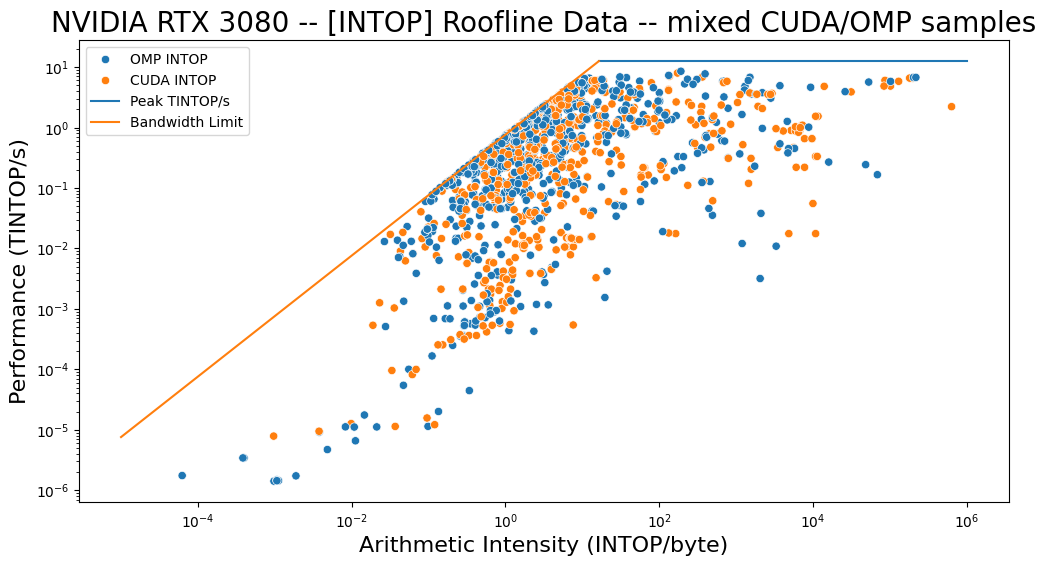

In [10]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)

# plot the intOPS roofline line
ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e6], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([1e-5, intOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,intOPMaxPerfTFLOP], label='Max Bandwidth')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(f'{gpuName} -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TINTOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP INTOP', 'CUDA INTOP', 'Peak TINTOP/s', 'Bandwidth Limit']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

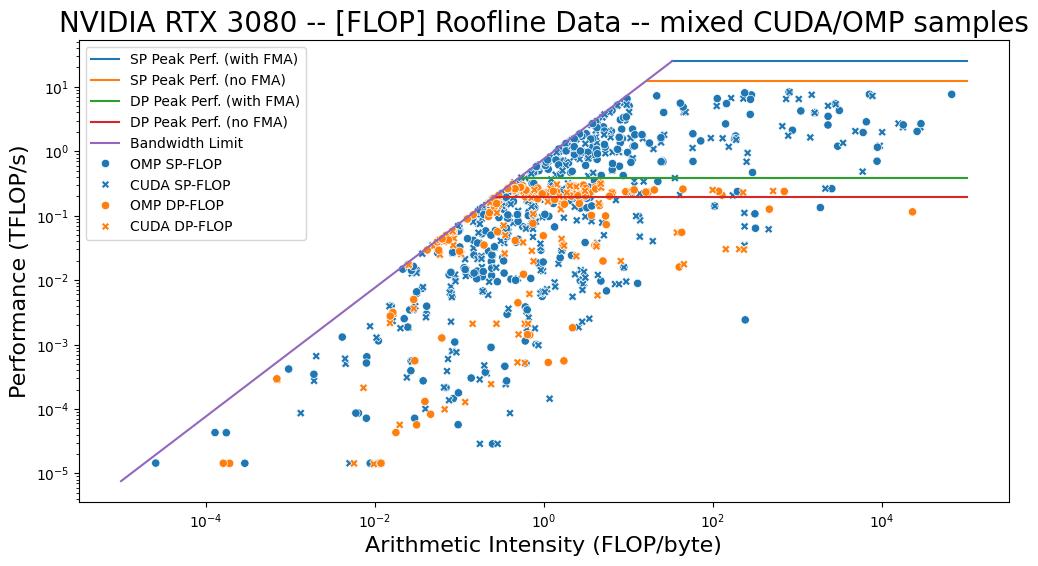

In [11]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))



# plot the SPOPS roofline line
ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')

# plot the DPOPS roofline line
ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')

ax.plot([dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')

# plot the roofline slanted line
ax.plot([1e-5, spOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,spOPMaxPerfTFLOP], label='Max Bandwidth')

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TFLOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

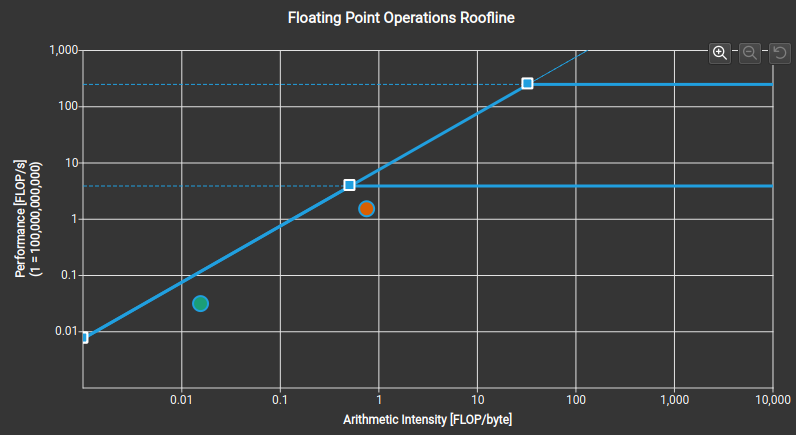

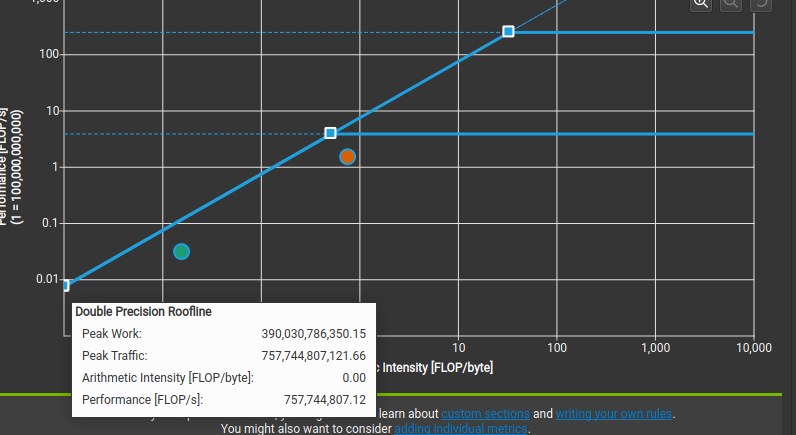

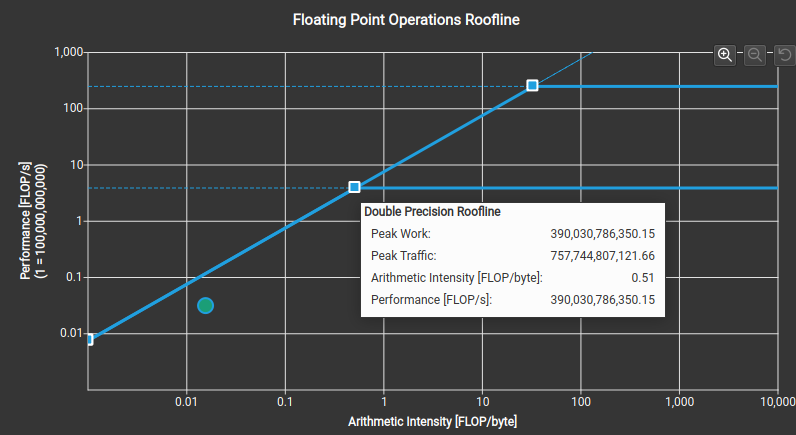

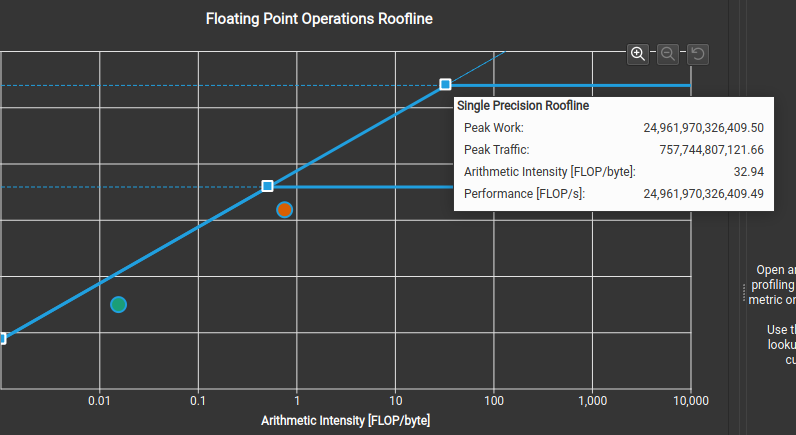

### Let's get some statistics about the data

In [12]:
print(df.columns)


Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')


In [13]:
# how many different kernel invocations did we capture?
totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 548
Total unique kernel executions recorded: 1309
Number of kernels with no arithmetic intensity (AI) 556 (42.48%)
Number of non-zero AI single-precision kernels recorded: 645 (49.27%)
Number of non-zero AI double-precision kernels recorded: 216 (16.5%)
Number of non-zero Perf single-precision kernels recorded: 645 (49.27%)
Number of non-zero Perf double-precision kernels recorded: 216 (16.5%)
Number of non-zero Perf intop kernels recorded: 1308 (99.92%)
Number of non-zero AI intop kernels recorded: 1308 (99.92%)


In [14]:
spData = df[(df['spAI'] > 0)]
dpData = df[(df['dpAI'] > 0)]

#subdata = df[(df['spPerf'] > 0) | (df['dpPerf'] > 0) | (df['spAI'] > 0) | (df['dpAI'] > 0) ]
print('SP data')
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

print()
print('DP data')
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

SP data
spPerf        8.331123
dpPerf        0.320184
spAI      66814.162987
dpAI        699.293698
dtype: float64
spPerf    0.000014
dpPerf    0.000000
spAI      0.000026
dpAI      0.000000
dtype: float64
spPerf    0.148808
dpPerf    0.000000
spAI      1.027578
dpAI      0.000000
dtype: float64
spPerf      0.808197
dpPerf      0.028750
spAI      487.934666
dpAI        3.517098
dtype: float64

DP data
spPerf        2.891806
dpPerf        0.320184
spAI       3472.896445
dpAI      23004.943886
dtype: float64
spPerf    0.000000
dpPerf    0.000014
spAI      0.000000
dpAI      0.000162
dtype: float64
spPerf    0.000000
dpPerf    0.123078
spAI      0.000000
dpAI      0.717618
dtype: float64
spPerf      0.076867
dpPerf      0.129344
spAI       36.446537
dpAI      119.406211
dtype: float64


In [15]:

def plotAIHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpAI', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intAI', ax=ax2)
    sns.ecdfplot(subdf, x='spAI', ax=ax2)
    sns.ecdfplot(subdf, x='dpAI', ax=ax2)

    ax.set_xlabel('Arithmetic Intensity (TeraOP/byte)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Arithmetic Intensity {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

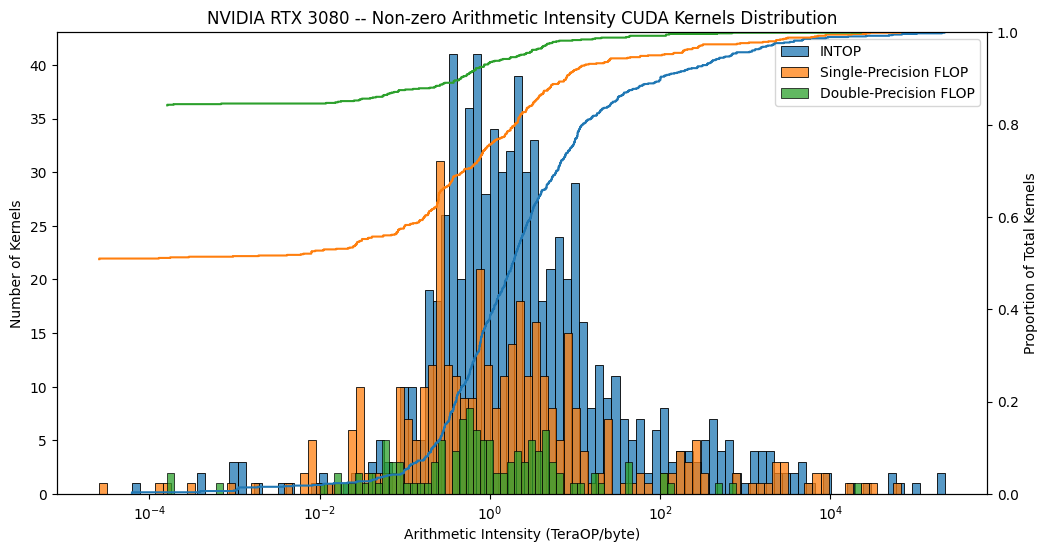

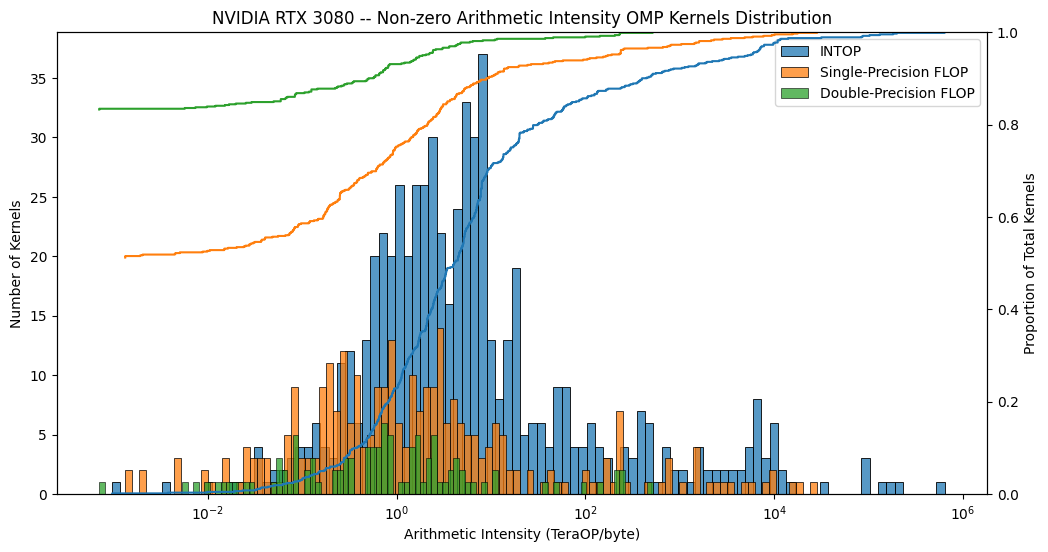

In [16]:
plotAIHistogram(df, 'CUDA')
plotAIHistogram(df, 'OMP')

In [17]:
#subdf = df[df['targetName'].isin(['bspline-vgh-cuda'])].copy().reset_index()
#
#print(subdf)
#
#print(type(subdf.iloc[0]['exeArgs']))
#
#grpA = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs'])
#grpB = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size'])
#
#
#print(grpA)
#print(grpB)
#
#print(grpA.ngroups)
#print(grpB.ngroups)

In [18]:
# what does the AI distribution look like? (violin plot + histogram)

def plotPerfHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpPerf', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intPerf', ax=ax2)
    sns.ecdfplot(subdf, x='spPerf', ax=ax2)
    sns.ecdfplot(subdf, x='dpPerf', ax=ax2)

    ax.set_xlabel('Performance (TeraOP/s)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Performance {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

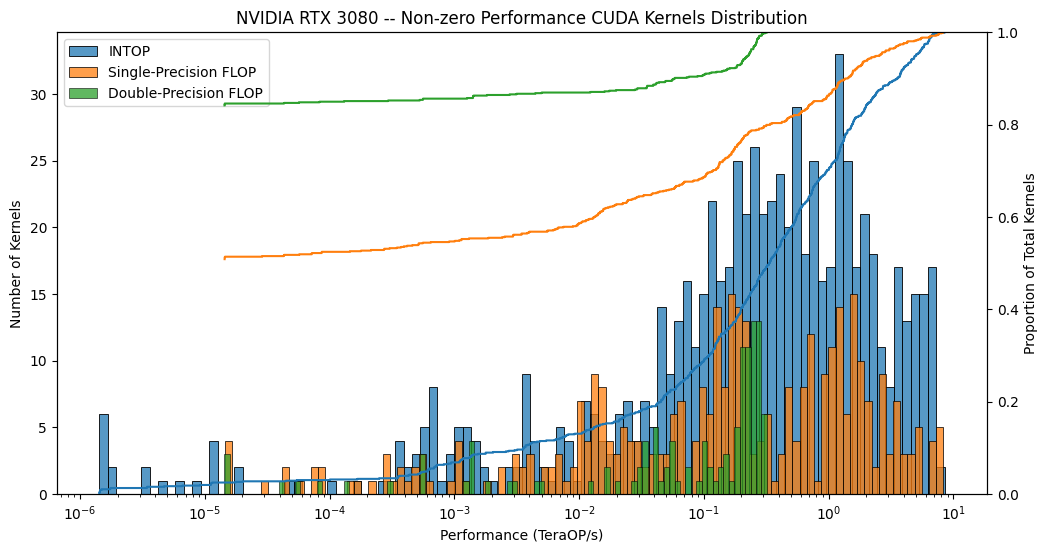

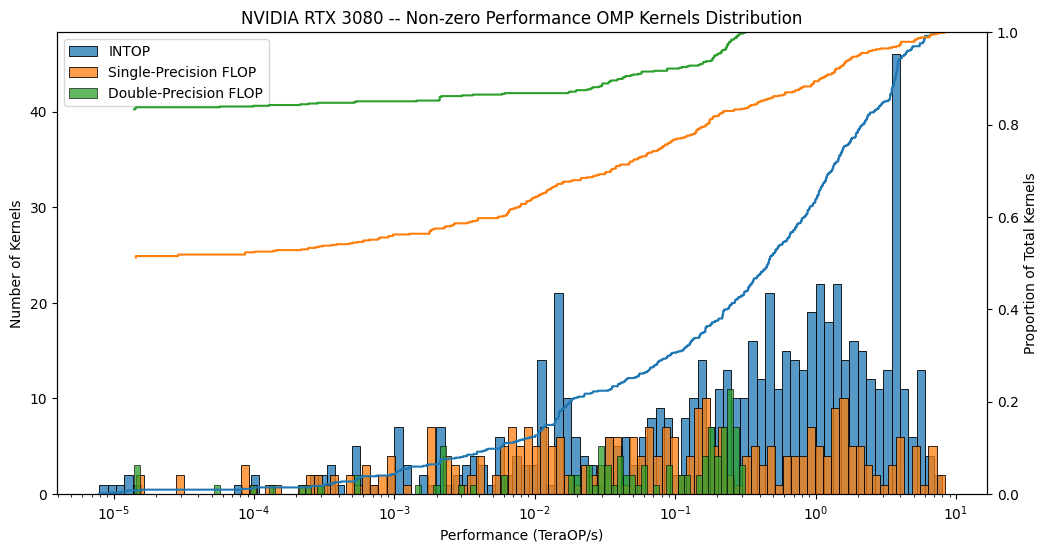

In [19]:
plotPerfHistogram(df, 'CUDA')
plotPerfHistogram(df, 'OMP')

### Visualize the Block and Grid Sizes

In [20]:
# because the sizes are in 3D, let's convert them to 1D by multiplying them


def strTupleTo1D(strTuple):
    finds = re.findall(r'\d+', strTuple)
    nums = [int(find) for find in finds]

    assert len(nums) == 3

    mult = 1
    for num in nums:
        mult = mult*num
    return mult


df['blockSz'] = df['Block Size'].apply(strTupleTo1D).astype(int)
df['gridSz'] = df['Grid Size'].apply(strTupleTo1D).astype(int)

print(df.head())


                                         Kernel Name       traffic      dpAI  \
0  haccmk_kernel(int, int, const float *, const f...  7.156462e+07  0.000000   
1  bit_rev_permutation(long *, const long *, unsi...  4.585366e+09  0.000000   
2  bit_rev_permutation_z(long *, const long *, un...  6.496454e+09  0.000000   
3  initial_value(unsigned int, double, double, do...  2.528404e+10  9.317279   
4  solve(unsigned int, double, double, double, do...  5.187426e+11  0.563661   

          spAI    dpPerf    spPerf      xtime    Block Size      Grid Size  \
0  1868.406255  0.000000  0.133712  2990528.0   (256, 1, 1)      (4, 1, 1)   
1     0.000000  0.000000  0.000000     3936.0  (1024, 1, 1)      (1, 1, 1)   
2     0.000000  0.000000  0.000000     4512.0    (32, 1, 1)      (2, 1, 1)   
3     0.409507  0.235578  0.010354  6480864.0   (256, 1, 1)  (65536, 1, 1)   
4     0.000000  0.292395  0.000000   516416.0   (256, 1, 1)  (65536, 1, 1)   

                    device       intops   intPerf 

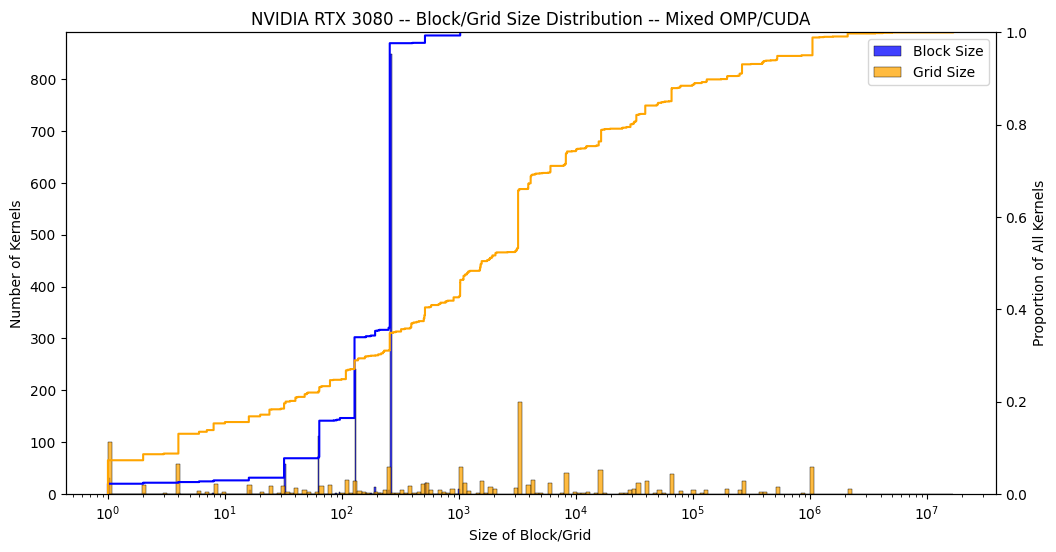

In [21]:

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='blockSz', bins=200, ax=ax, log_scale=True, color='blue')
#sns.histplot(df, x='blockSz', bins=100, ax=ax, log_scale=True, hue='language')
sns.histplot(df, x='gridSz', bins=200, ax=ax, log_scale=True, color='orange')
#sns.histplot(df, x='gridSz', bins=100, ax=ax, log_scale=True, hue='language')
ax2 = ax.twinx()
sns.ecdfplot(df, x='blockSz', ax=ax2, color='blue')
sns.ecdfplot(df, x='gridSz', ax=ax2, color='orange')
#sns.ecdfplot(df, x='blockSz', ax=ax2, hue='language')
#sns.ecdfplot(df, x='gridSz', ax=ax2, hue='language')

ax.set_xlabel('Size of Block/Grid')
ax.set_ylabel('Number of Kernels')
ax2.set_ylabel('Proportion of All Kernels')

ax.set_title(f'{gpuName} -- Block/Grid Size Distribution -- Mixed OMP/CUDA')

ax.legend(['Block Size', 'Grid Size'])
#ax2.legend()

plt.show()

In [22]:
# let's print the top 5 grid sizes and top 5 block sizes

#topBlockSzs = df.groupby('blockSz', 'language').count().reset_index().nlargest(5, ['language', 'Kernel Name', 'blockSz']).reset_index(drop=True)[['blockSz', 'Kernel Name']]
topn = 10

topBlockSzsJoined = df.groupby(['blockSz']).count().reset_index()
topBlockSzsOverall = topBlockSzsJoined.nlargest(topn, ['Kernel Name', 'blockSz'])[['Kernel Name', 'blockSz']]
numKernels = topBlockSzsJoined['Kernel Name'].sum()
topBlockSzsOverall['percent'] = 100*topBlockSzsOverall['Kernel Name']/numKernels

topBlockSzsOverall = topBlockSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsOverall)

topBlockSzs = df.groupby(['blockSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'blockSz'])

numKernelsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP']['Kernel Name'].sum()

topBlockSzsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]
topBlockSzsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]

topBlockSzsCUDA['percent'] = 100*topBlockSzsCUDA['Kernel Name']/numKernelsCUDA
topBlockSzsOMP['percent'] = 100*topBlockSzsOMP['Kernel Name']/numKernelsOMP

topBlockSzsCUDA = topBlockSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topBlockSzsOMP = topBlockSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsCUDA)
display(topBlockSzsOMP)


,Num Kernels,blockSz,percent
0,848,256,61.538462
1,241,128,17.489115
2,108,64,7.837446
3,58,32,4.208999
4,31,1,2.249637
5,22,512,1.596517
6,14,192,1.015965
7,10,1024,0.725689
8,8,16,0.580552
9,6,250,0.435414


,language,Num Kernels,blockSz,percent
0,CUDA,449,256,59.313078
1,CUDA,132,128,17.437252
2,CUDA,67,64,8.850727
3,CUDA,26,32,3.434610
4,CUDA,24,1,3.170410
5,CUDA,17,512,2.245707
6,CUDA,9,1024,1.188904
7,CUDA,8,192,1.056803
8,CUDA,4,16,0.528402
9,CUDA,3,250,0.396301


,language,Num Kernels,blockSz,percent
0,OMP,399,256,64.251208
1,OMP,109,128,17.552335
2,OMP,41,64,6.602254
3,OMP,32,32,5.152979
4,OMP,7,1,1.127214
5,OMP,6,192,0.966184
6,OMP,5,512,0.805153
7,OMP,4,16,0.644122
8,OMP,3,250,0.483092
9,OMP,2,96,0.322061


In [23]:
# let's print the top 5 grid sizes and top 5 block sizes

topn = 10
topGridSzs = df.groupby(['gridSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'gridSz'])

topgridSzsJoined = df.groupby(['gridSz']).count().reset_index()
topgridSzsOverall = topgridSzsJoined.nlargest(topn, ['Kernel Name', 'gridSz'])[['Kernel Name', 'gridSz']]
numKernels = topgridSzsJoined['Kernel Name'].sum()
topgridSzsOverall['percent'] = 100*topgridSzsOverall['Kernel Name']/numKernels

topgridSzsOverall = topgridSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topgridSzsOverall)

numKernelsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topGridSzs[topGridSzs['language'] == 'OMP']['Kernel Name'].sum()

topGridSzsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]
topGridSzsOMP = topGridSzs[topGridSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]

topGridSzsCUDA['percent'] = 100*topGridSzsCUDA['Kernel Name']/numKernelsCUDA
topGridSzsOMP['percent'] = 100*topGridSzsOMP['Kernel Name']/numKernelsOMP

topGridSzsCUDA = topGridSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topGridSzsOMP = topGridSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
display(topGridSzsCUDA)
display(topGridSzsOMP)


,Num Kernels,gridSz,percent
0,170,3200,12.336720
1,101,1,7.329463
2,59,4,4.281567
3,53,1048576,3.846154
4,50,256,3.628447
5,38,65536,2.757620
6,36,1024,2.612482
7,34,16384,2.467344
8,28,8192,2.031930
9,26,128,1.886792


,language,Num Kernels,gridSz,percent
0,CUDA,66,1,8.718626
1,CUDA,34,65536,4.491413
2,CUDA,26,108,3.434610
3,CUDA,24,39063,3.170410
4,CUDA,24,256,3.170410
5,CUDA,22,16384,2.906209
6,CUDA,22,8192,2.906209
7,CUDA,20,1024,2.642008
8,CUDA,18,1048576,2.377807
9,CUDA,18,262144,2.377807


,language,Num Kernels,gridSz,percent
0,OMP,170,3200,27.375201
1,OMP,50,4,8.051530
2,OMP,35,1048576,5.636071
3,OMP,35,1,5.636071
4,OMP,26,256,4.186795
5,OMP,16,1024,2.576490
6,OMP,12,16384,1.932367
7,OMP,12,6048,1.932367
8,OMP,11,128,1.771337
9,OMP,11,8,1.771337


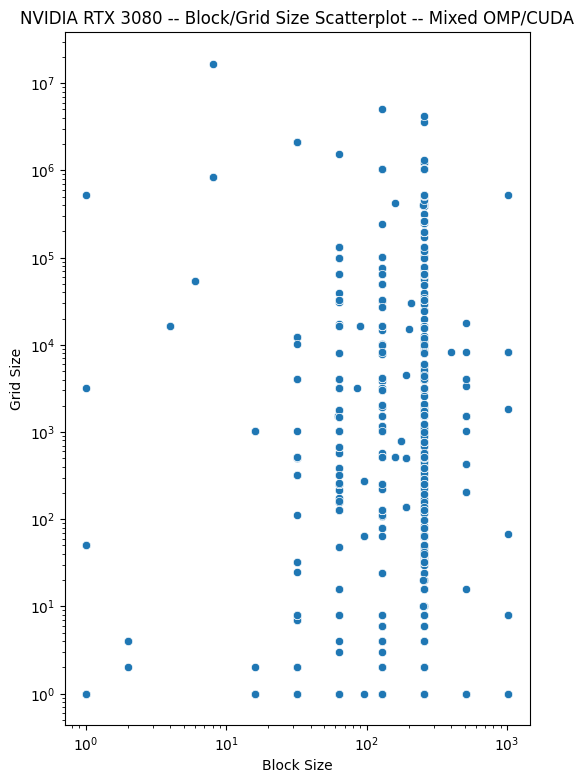

In [24]:

fig, ax = plt.subplots(1, figsize=(6,9))

sns.scatterplot(df, x='blockSz', y='gridSz', ax=ax)

ax.set_title(f'{gpuName} -- Block/Grid Size Scatterplot -- Mixed OMP/CUDA')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Block Size')
ax.set_ylabel('Grid Size')

plt.show()

In [25]:
uniqBlockSzs = sorted(df['blockSz'].unique().tolist())
print(f'num unique block sizes: {len(uniqBlockSzs)}: {uniqBlockSzs}')

print()
uniqGridSzs = sorted(list(df['gridSz'].unique().tolist()))
print(f'num unique grid  sizes: {len(uniqGridSzs)}: {uniqGridSzs}')

num unique block sizes: 24: [1, 2, 4, 6, 8, 16, 32, 63, 64, 85, 90, 96, 128, 160, 176, 192, 200, 208, 250, 255, 256, 400, 512, 1024]

num unique grid  sizes: 214: [1, 2, 3, 4, 6, 7, 8, 10, 16, 20, 24, 25, 30, 32, 33, 36, 40, 41, 42, 48, 50, 51, 63, 64, 66, 68, 79, 84, 99, 108, 112, 118, 128, 137, 138, 157, 161, 169, 176, 193, 204, 216, 224, 225, 229, 255, 256, 257, 274, 288, 320, 343, 380, 384, 391, 400, 408, 435, 455, 500, 506, 510, 511, 512, 560, 576, 578, 588, 669, 693, 768, 797, 899, 1000, 1017, 1022, 1024, 1025, 1088, 1093, 1122, 1130, 1160, 1171, 1200, 1236, 1500, 1513, 1524, 1525, 1530, 1531, 1536, 1563, 1737, 1792, 1823, 1844, 1849, 1898, 1920, 1930, 2048, 2088, 2605, 2997, 3062, 3072, 3125, 3199, 3200, 3240, 3328, 3845, 3907, 3969, 4096, 4097, 4120, 4136, 4143, 4213, 4225, 4429, 4512, 4883, 5184, 5760, 6000, 6048, 7813, 8000, 8160, 8184, 8192, 8296, 8386, 9216, 10000, 10240, 10929, 12000, 12208, 12500, 14826, 15000, 15625, 16384, 16650, 17536, 17576, 19532, 24692, 25000, 27000

## Read in the JSON files with the scraped kernels

In [26]:
import json
from pprint import pprint
from tqdm import tqdm

from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import UserMessage, SystemMessage, AssistantMessage
from autogen_core.model_context import UnboundedChatCompletionContext
from autogen_agentchat.agents import AssistantAgent


import subprocess
import shlex
from io import StringIO
import re

In [27]:
with open('simple-scraped-kernels-CUDA-pruned.json', 'r') as file:
    scrapedCUDA = json.load(file)

with open('simple-scraped-kernels-OMP-pruned.json', 'r') as file:
    scrapedOMP = json.load(file)


scrapedCodes = scrapedCUDA + scrapedOMP

In [28]:
pprint(scrapedCodes[0])

{'basename': 'accuracy-cuda',
 'exe': '/home/gbolet/hecbench-roofline/build/accuracy-cuda',
 'kernelNames': ['accuracy_kernel'],
 'kernels': {'accuracy_kernel': '-----------------------------------\n'
                                'reference.h\n'
                                '-----------------------------------\n'
                                'int reference (\n'
                                '    const int N,\n'
                                '    const int D,\n'
                                '    const int top_k,\n'
                                '    const float* Xdata,\n'
                                '    const int* labelData)\n'
                                '{\n'
                                '  int count = 0;\n'
                                '  for (int row = 0; row < N; row++) {\n'
                                '    const int label = labelData[row];\n'
                                '    const float label_pred = Xdata[row * D + '
                       

## Match up the kernels with their JSON and save to a file

In [29]:
def chat_history_to_json_line(ctxMessages:list):
    jsonDict = {'messages':[]}
    for msg in ctxMessages:
        if type(msg) == SystemMessage:
            role = 'system'
        elif type(msg) == UserMessage:
            role = 'user'
        elif type(msg) == AssistantMessage:
            role = 'assistant'
        else:
            assert False, f'Unknown message type: {type(msg)} of {msg}'
        content = msg.content

        jsonDict['messages'].append({'role':role, 'content':content})

    return json.dumps(jsonDict, allow_nan=False)

In [30]:
def demangle_omp_kernel_name(mangledName):

    regex = r'_(?:[^_]+_){4}(.*)(_l[\d]+)'
    matches = re.finditer(regex, mangledName, re.MULTILINE)

    matches = [i for i in matches]
    assert len(matches) == 1

    cleanName = ''
    for match in matches:
        groups = match.groups()
        assert len(groups) == 2
        cleanName = groups[0]
        break


    filterCommand = f'llvm-cxxfilt {cleanName}'
    
    #print(shlex.split(cuobjdumpCommand))
    demangleResult = subprocess.run(filterCommand, shell=True, timeout=5, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    assert demangleResult.returncode == 0
    
    demangled = demangleResult.stdout.decode('UTF-8').strip()

    return demangled

In [31]:
# this system message combines the device information and the non-detailed few-shot
# examples. We need some few-shot breif examples of the output so that the model 
# knows how to respond.
systemMessage = '''You are a GPU performance analysis expert that classifies kernels into Arithmetic Intensity Roofline model categories based on their source code characteristics. Your task is to provide one of the following performance boundedness classifications: Compute or Bandwidth.  A kernel is considered Compute bound if its performance is primarily limited by the number of operations it performs, and Bandwidth bound if its performance is primarily limited by the rate at which data can be moved between memory and processing units.

Provide only one word as your response, chosen from the set: ['Compute', 'Bandwidth'].
**Examples:**
**Example 1:**
```
Kernel Source Code (simplified):
for i = 0 to 1000000 {
  a[i] = a[i] + b[i];
}
```
Response: Compute

**Example 2:**
```
Kernel Source Code (simplified):
for i = 0 to 10 {
  load_data(large_array);   //loads from large memory
  process_data(large_array); //processes data
  store_data(large_array);  //stores back to memory
}
```
Response: Bandwidth

**Example 3:**
```
Kernel Source Code (simplified):
for i = 0 to 1000 {
  vector_add(a,b,c);   //process data in situ
}
//Some smaller data movement but mostly compute.
```
Response: Compute

Now, analyze the following source codes for the requested CUDA or OpenMP (OMP) target offload kernel of the specified hardware.'''


def make_kernel_info_message(device, exeArgs, peakPerfGFLOPs, memBandwidthGBs, kernelName, blockSz, gridSz, language):
    assert kernelName != ''

    if language == 'OMP':
      cleanKName = demangle_omp_kernel_name(kernelName)
      assert cleanKName != ''
      beginPart = f'Classify the {language} kernel in function [{cleanKName}] as Bandwidth or Compute bound.'
    else:
      # if were prompting for a CUDA code
      cleanKName = kernelName
      beginPart = f'Classify the {language} kernel called [{cleanKName}] as Bandwidth or Compute bound.'

    builtPrompt = f'{beginPart} The system it will execute on is a [{device}] with a peak performance of {round(peakPerfGFLOPs,2)} GFLOP/s and a max bandwidth of {round(memBandwidthGBs,2)} GB/s. The block and grid sizes of the invoked kernel are {blockSz} and {gridSz}, respectively. The executable running this kernel is launched with '

    if exeArgs == '':
      builtPrompt += 'no command line arguments.'
    else:
      builtPrompt += f'the following command line arguments: [{exeArgs}].'

    builtPrompt += ' Below is the source code containing the kernel definition and other source code for the executable.'

    return builtPrompt

In [32]:
# the kernel name is from the "Kernel Name" column of the dataframe
async def makeJSONLine(kernel_info, kernelCode):

    sys_msg = SystemMessage(content=systemMessage)
    kernel_info_msg = UserMessage(source='User', content=kernel_info)
    code_msg = UserMessage(source='User', content=f'```{kernelCode}```')
    context = UnboundedChatCompletionContext(initial_messages=[sys_msg, kernel_info_msg, code_msg])

    messages = await context.get_messages()
    jline = chat_history_to_json_line(messages)

    return f'{jline}\n'

In [33]:

def writeToFile(filename, lines):
    # going to overwrite the whole file each time
    # it's redundant but the file wont be that large
    # so the speed doesn't matter
    with open(filename, 'w') as jsonLFile:
        jsonLFile.write(lines)

In [34]:
jsonLLines = ''

peakPerfGFLOPs = spOPMaxPerfTFLOP * 1e3
memBandwidthGBs = maxBandwidthTBPerSec * 1e3

# for each sample we got
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    targetName = row['targetName']
    kernelName = row['Kernel Name']
    exeArgs = row['exeArgs']
    blockSz = row['Block Size']
    gridSz = row['Grid Size']
    language = row['language']
    device = row['device']

    for elem in scrapedCodes:
        basename = elem['basename']
        if basename == targetName:
            kernelCode = list(elem['kernels'].values())[0]
            assert kernelCode != ''
            break


    infoMsg = make_kernel_info_message(device, exeArgs, peakPerfGFLOPs, memBandwidthGBs, kernelName, blockSz, gridSz, language)
    toAppend = await makeJSONLine(infoMsg, kernelCode)
    jsonLLines = jsonLLines + toAppend
    writeToFile('zero-shot-inference-queries.jsonl', jsonLLines)


100%|██████████| 1378/1378 [00:18<00:00, 74.61it/s]
